# Data Preprocessing

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define file paths for datasets
file_paths = {
    "stroke_data": "synthetic_stroke_data.csv",
    "lung_health_data": "synthetic_lung_health_data.csv",
    "lung_cancer_data": "synthetic_lung_cancer_data.csv"
}

# Define preprocessing function
def preprocess_dataset(data, name, target_column=None, drop_columns=[]):
    print(f"Processing {name} dataset...")

    # Handle missing values
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            if data[col].dtype == "object":
                data[col] = data[col].fillna(data[col].mode()[0])  # Fill with mode for categorical
            else:
                data[col] = data[col].fillna(data[col].mean())  # Fill with mean for numerical

    # Encode categorical variables
    categorical_columns = data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

    # Normalize numerical features
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # Separate features and target if target column is provided
    if target_column:
        X = data.drop(columns=[target_column] + drop_columns)
        y = data[target_column]
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        # Save to CSV
        X_train.to_csv(f"{name}_X_train.csv", index=False)
        X_test.to_csv(f"{name}_X_test.csv", index=False)
        y_train.to_csv(f"{name}_y_train.csv", index=False)
        y_test.to_csv(f"{name}_y_test.csv", index=False)
        print(f"Processed {name} dataset saved (train/test splits).")
    else:
        # Save entire processed dataset if no target column
        data.to_csv(f"{name}_processed.csv", index=False)
        print(f"Processed {name} dataset saved as a single file.")

# Preprocess datasets
datasets_info = {
    "stroke_data": {
        "target_column": "stroke",
        "drop_columns": ["id"]
    },
    "lung_health_data": {
        "target_column": "Lung_Capacity",
        "drop_columns": []
    },
    "lung_cancer_data": {
        "target_column": "Lung_Cancer",
        "drop_columns": []
    }
}

for name, info in datasets_info.items():
    # Load dataset
    data = pd.read_csv(file_paths[name])
    preprocess_dataset(data, name, target_column=info["target_column"], drop_columns=info["drop_columns"])

print("All datasets have been processed successfully!")


Processing stroke_data dataset...
Processed stroke_data dataset saved (train/test splits).
Processing lung_health_data dataset...
Processed lung_health_data dataset saved (train/test splits).
Processing lung_cancer_data dataset...
Processed lung_cancer_data dataset saved (train/test splits).
All datasets have been processed successfully!


# Trainig the Model

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
import joblib  # You may keep joblib if you still want .pkl as an option

# Define file paths for training and testing datasets
datasets = {
    "stroke_data": {
        "X_train": "stroke_data_X_train.csv",
        "X_test": "stroke_data_X_test.csv",
        "y_train": "stroke_data_y_train.csv",
        "y_test": "stroke_data_y_test.csv",
        "task": "classification"
    },
    "lung_health_data": {
        "X_train": "lung_health_data_X_train.csv",
        "X_test": "lung_health_data_X_test.csv",
        "y_train": "lung_health_data_y_train.csv",
        "y_test": "lung_health_data_y_test.csv",
        "task": "regression"
    },
    "lung_cancer_data": {
        "X_train": "lung_cancer_data_X_train.csv",
        "X_test": "lung_cancer_data_X_test.csv",
        "y_train": "lung_cancer_data_y_train.csv",
        "y_test": "lung_cancer_data_y_test.csv",
        "task": "classification"
    }
}

def preprocess_target(y, task):
    """
    Ensure the target variable is appropriate for the specified task.
    For classification, discretize continuous targets if necessary.
    """
    if task == "classification" and y.dtype.kind in 'fc':  # Continuous target for classification
        # Example: Convert to binary based on mean
        y = (y > y.mean()).astype(int)
    return y

def train_and_evaluate(name, X_train_path, X_test_path, y_train_path, y_test_path, task="classification"):
    print(f"\nTraining model for {name} dataset ({task})...")

    # Load the datasets
    X_train = pd.read_csv(X_train_path)
    X_test = pd.read_csv(X_test_path)
    y_train = pd.read_csv(y_train_path).values.ravel()
    y_test = pd.read_csv(y_test_path).values.ravel()

    # Preprocess target variable
    y_train = preprocess_target(y_train, task)
    y_test = preprocess_target(y_test, task)

    if task == "classification":
        # Address class imbalance using SMOTE only if target has multiple classes
        if len(np.unique(y_train)) > 1:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        model = RandomForestClassifier(random_state=42, class_weight="balanced")

        # Cross-validation for reliability
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")

        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred_test = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_test)
        print(f"Accuracy for {name}: {accuracy:.2f}")
        print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_test))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred_test))

        # --- Optionally get predicted probabilities
        if hasattr(model, "predict_proba"):
            y_proba_test = model.predict_proba(X_test)[:, 1]  # Probability of class=1
        else:
            y_proba_test = None

        # Save results to CSV (test set)
        results_test = pd.DataFrame({
            "Actual": y_test,
            "Predicted": y_pred_test
        })
        if y_proba_test is not None:
            results_test["Predicted_Probability"] = y_proba_test
        
        csv_filename_test = f"{name}_test_predictions.csv"
        results_test.to_csv(csv_filename_test, index=False)
        print(f"Test predictions saved to {csv_filename_test}")

        # --- If you want training predictions as well, uncomment:
        # y_pred_train = model.predict(X_train)
        # train_results = pd.DataFrame({
        #     "Actual": y_train,
        #     "Predicted": y_pred_train
        # })
        # if y_proba_test is not None:
        #     y_proba_train = model.predict_proba(X_train)[:, 1]
        #     train_results["Predicted_Probability"] = y_proba_train
        # csv_filename_train = f"{name}_train_predictions.csv"
        # train_results.to_csv(csv_filename_train, index=False)
        # print(f"Train predictions saved to {csv_filename_train}")

    elif task == "regression":
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        print(f"Mean Squared Error for {name}: {mse:.2f}")
        print(f"R-squared for {name}: {r2:.2f}")

        # Save predictions to CSV
        results_test = pd.DataFrame({
            "Actual": y_test,
            "Predicted": y_pred_test
        })
        csv_filename_test = f"{name}_test_predictions.csv"
        results_test.to_csv(csv_filename_test, index=False)
        print(f"Test predictions saved to {csv_filename_test}")

        # --- If you also want training set predictions:
        # y_pred_train = model.predict(X_train)
        # train_results = pd.DataFrame({
        #     "Actual": y_train,
        #     "Predicted": y_pred_train
        # })
        # csv_filename_train = f"{name}_train_predictions.csv"
        # train_results.to_csv(csv_filename_train, index=False)
        # print(f"Train predictions saved to {csv_filename_train}")

    else:
        raise ValueError("Task must be either 'classification' or 'regression'.")

    # If you still want to keep a .pkl, you can leave this line:
    # joblib.dump(model, f"{name}_model.pkl")

    return model

# Train and evaluate models for all datasets
for name, paths in datasets.items():
    train_and_evaluate(
        name,
        X_train_path=paths["X_train"],
        X_test_path=paths["X_test"],
        y_train_path=paths["y_train"],
        y_test_path=paths["y_test"],
        task=paths["task"]
    )
    
import pandas as pd
import numpy as np

# Number of records to generate
num_records = 500000

# Define regions with varying probabilities
regions = ["North America", "Europe", "Asia", "South America", "Africa", "Australia"]
region_probabilities = [0.15, 0.2, 0.25, 0.15, 0.15, 0.1]  # Adjust probabilities for each region

# Generate Lung Cancer dataset with variability
lung_cancer_data = {
    "Patient_ID": [f"LC{str(i).zfill(7)}" for i in range(1, num_records + 1)],
    "Age": np.random.randint(30, 85, num_records),
    "Gender": np.random.choice(["Male", "Female"], num_records),
    "Smoking_History": np.random.choice(["Non-Smoker", "Former Smoker", "Current Smoker"], num_records),
    "Cancer_Stage": np.random.choice(["Stage I", "Stage II", "Stage III", "Stage IV"], num_records, p=[0.2, 0.3, 0.3, 0.2]),
    "Diagnosis_Year": np.random.randint(2000, 2023, num_records),
    "Treatment_Type": np.random.choice(["Chemotherapy", "Radiation", "Surgery", "Immunotherapy"], num_records),
    "Survival_Years": np.random.randint(0, 15, num_records),
    "Outcome": np.random.choice(["Survived", "Deceased"], num_records, p=[0.6, 0.4]),
    "Region": np.random.choice(regions, num_records, p=region_probabilities)
}
lung_cancer_df = pd.DataFrame(lung_cancer_data)

# Generate Stroke dataset with variability
stroke_data = {
    "Patient_ID": [f"ST{str(i).zfill(7)}" for i in range(1, num_records + 1)],
    "Age": np.random.randint(30, 85, num_records),
    "Gender": np.random.choice(["Male", "Female"], num_records),
    "Hypertension": np.random.choice(["Yes", "No"], num_records, p=[0.4, 0.6]),
    "Heart_Disease": np.random.choice(["Yes", "No"], num_records, p=[0.3, 0.7]),
    "Ever_Married": np.random.choice(["Yes", "No"], num_records, p=[0.7, 0.3]),
    "Work_Type": np.random.choice(["Private", "Self-employed", "Govt_job", "Children", "Never_worked"], num_records),
    "Residence_Type": np.random.choice(["Urban", "Rural"], num_records),
    "Avg_Glucose_Level": np.random.uniform(70, 250, num_records),
    "BMI": np.random.uniform(18.5, 40, num_records),
    "Stroke": np.random.choice(["Yes", "No"], num_records, p=[0.2, 0.8]),
    "Region": np.random.choice(regions, num_records, p=region_probabilities)
}
stroke_df = pd.DataFrame(stroke_data)

# Save the datasets to CSV files
lung_cancer_df.to_csv("Lung_Cancer_Data.csv", index=False)
stroke_df.to_csv("Stroke_Data.csv", index=False)

print("Datasets generated with variability and saved as 'Lung_Cancer_Data.csv' and 'Stroke_Data.csv'.")


Training model for stroke_data dataset (classification)...
Accuracy for stroke_data: 0.93
Cross-Validation Accuracy: 0.96 ± 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2843
           1       0.07      0.04      0.05       157

    accuracy                           0.93      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.90      0.93      0.91      3000


Confusion Matrix:
[[2769   74]
 [ 151    6]]
Test predictions saved to stroke_data_test_predictions.csv

Training model for lung_health_data dataset (regression)...
Mean Squared Error for lung_health_data: 0.08
R-squared for lung_health_data: 0.91
Test predictions saved to lung_health_data_test_predictions.csv

Training model for lung_cancer_data dataset (classification)...
Accuracy for lung_cancer_data: 0.92
Cross-Validation Accuracy: 0.94 ± 0.00

Classification Report:
              precision    recall  f1-scor

# Predicting Insights


Generating insights for Stroke Predictions...


c:\Users\smart\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\smart\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy:  0.93
Precision: 0.07
Recall:    0.04
F1-score:  0.05

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.95      0.97      0.96      2843
      Stroke       0.07      0.04      0.05       157

    accuracy                           0.93      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.90      0.93      0.91      3000



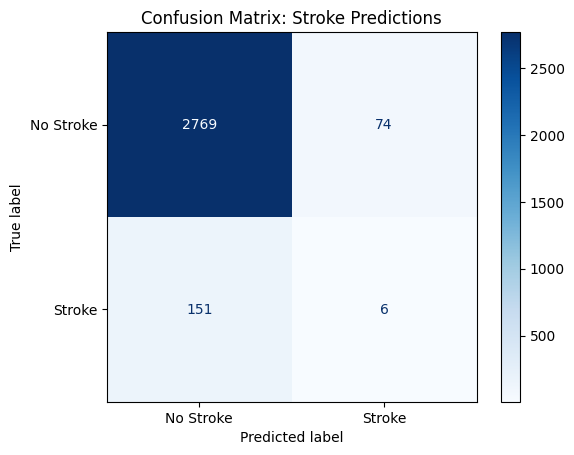

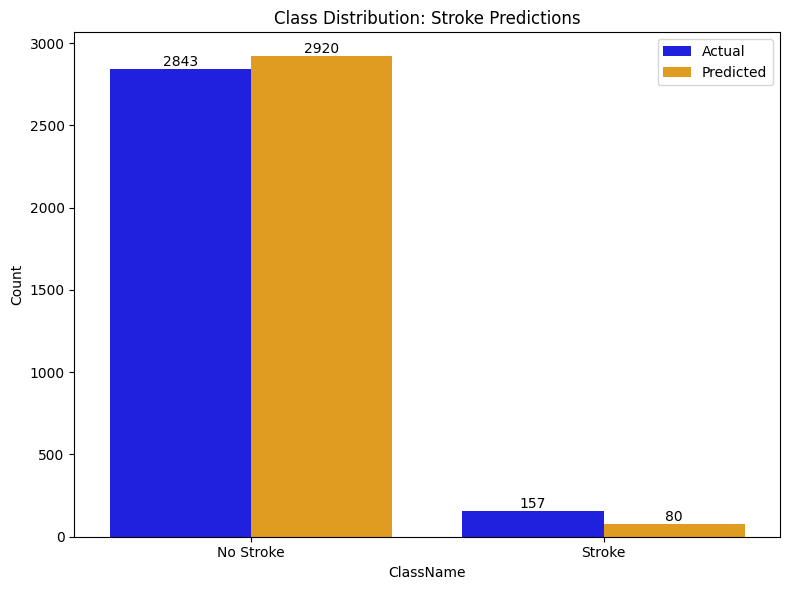

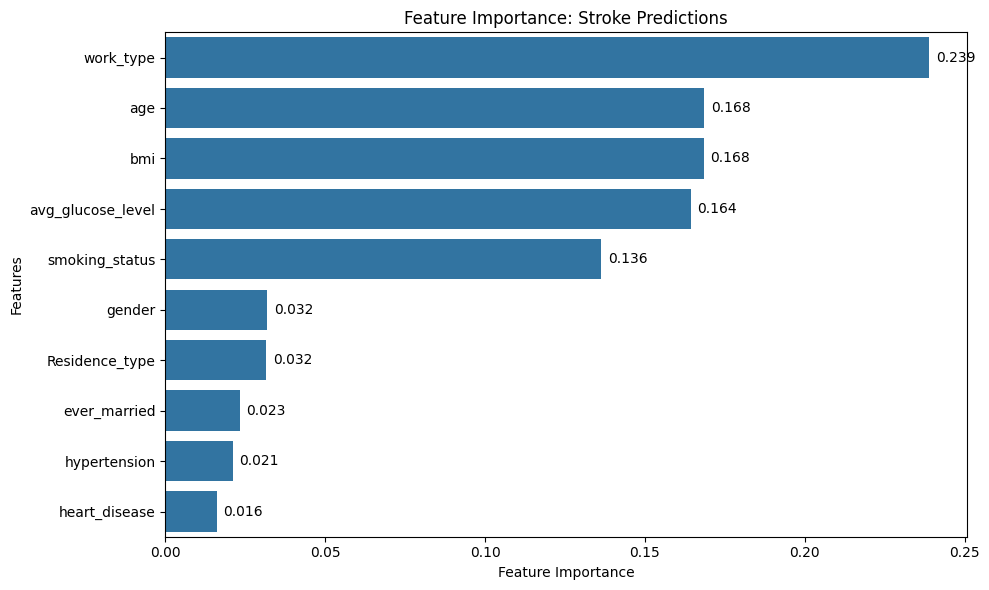

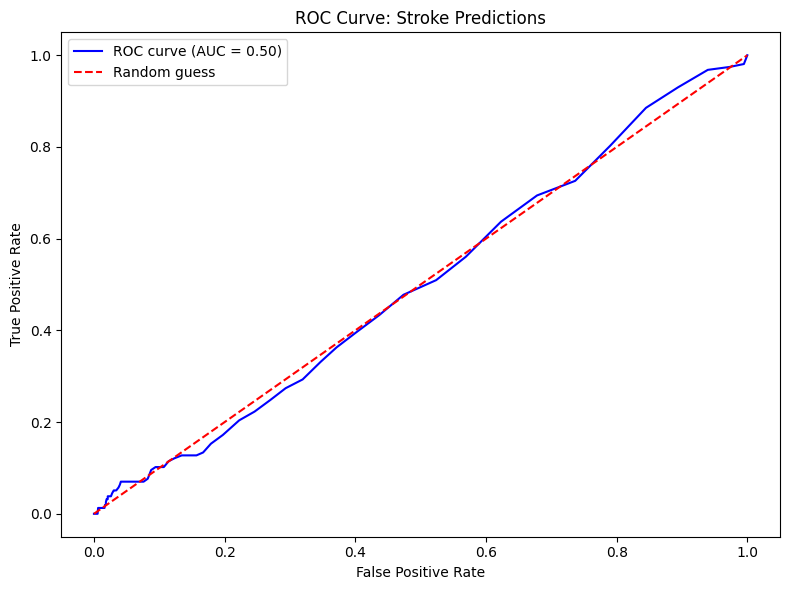

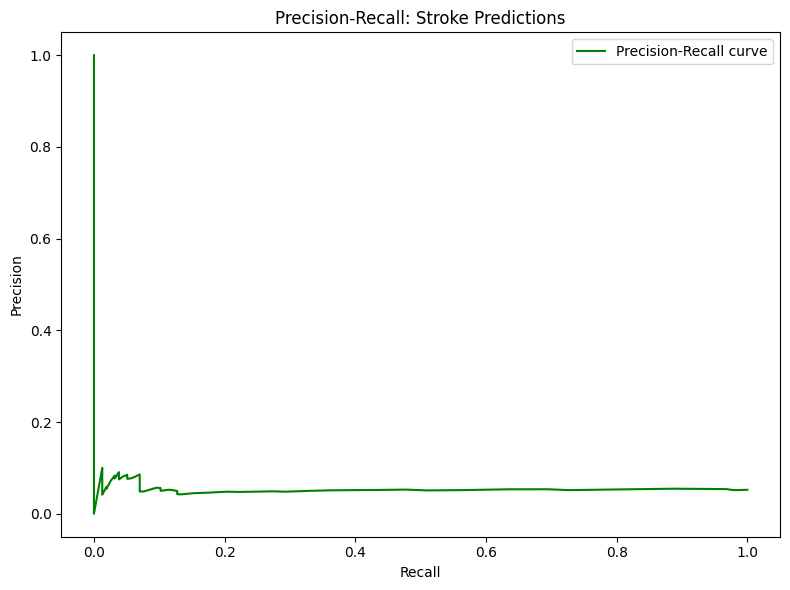

[WARNING] Partial Dependence failed: cannot reshape array of size 1 into shape (2)

Projected Stroke Predictions in 5 years: 128

----- Plain-English Insight -----
For Stroke Predictions, we achieved an overall accuracy of 92.5%.
Among all predicted Stroke cases, about 7.5% are truly Stroke.
Out of all real Stroke cases, we detected 3.8%.
We predict about 80 Stroke cases at present, potentially growing to ~128 in 5 years.
These insights can help shape preventive strategies and resource allocation.


Generating insights for Lung Health Analysis...


c:\Users\smart\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mean Squared Error:      0.08
Root Mean Squared Error: 0.29
Mean Absolute Error:     0.22
R-squared:               0.91


c:\Users\smart\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


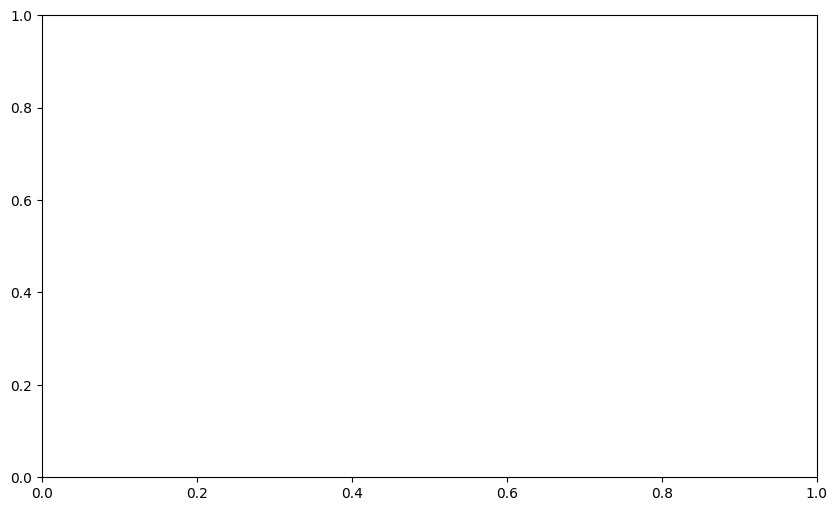

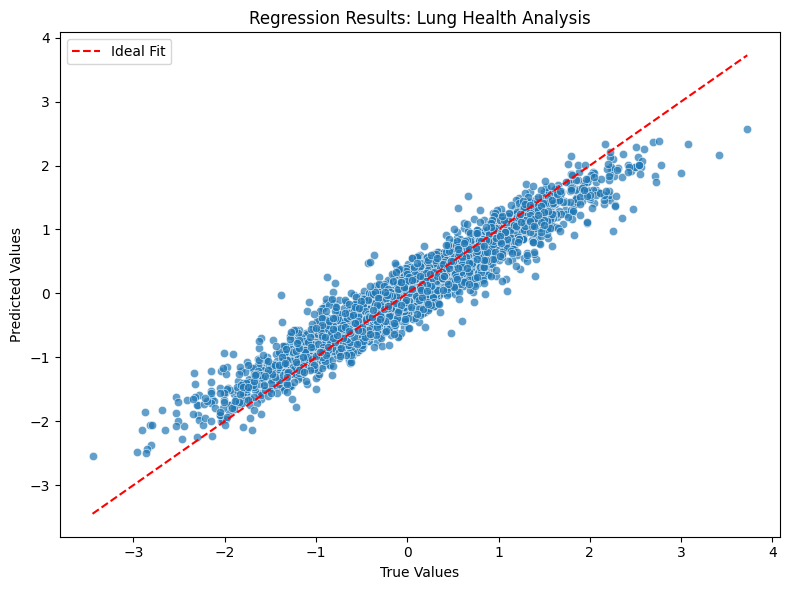

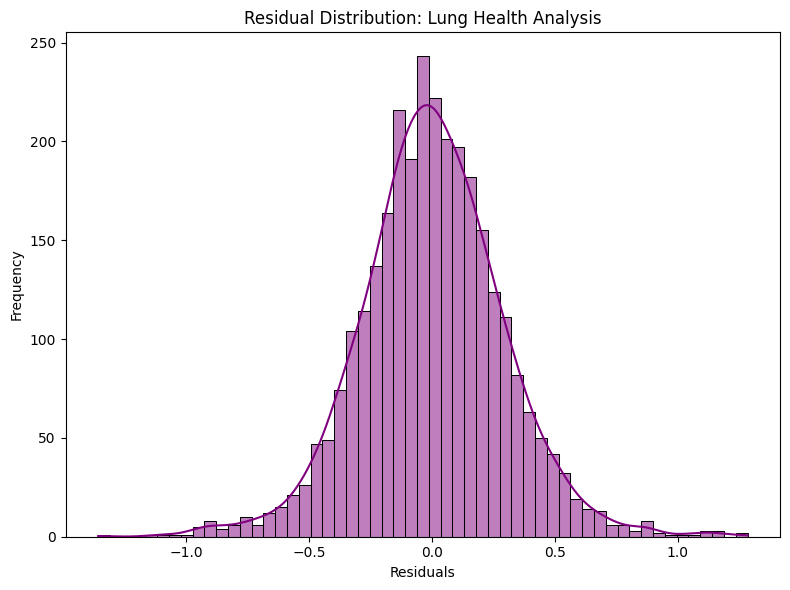

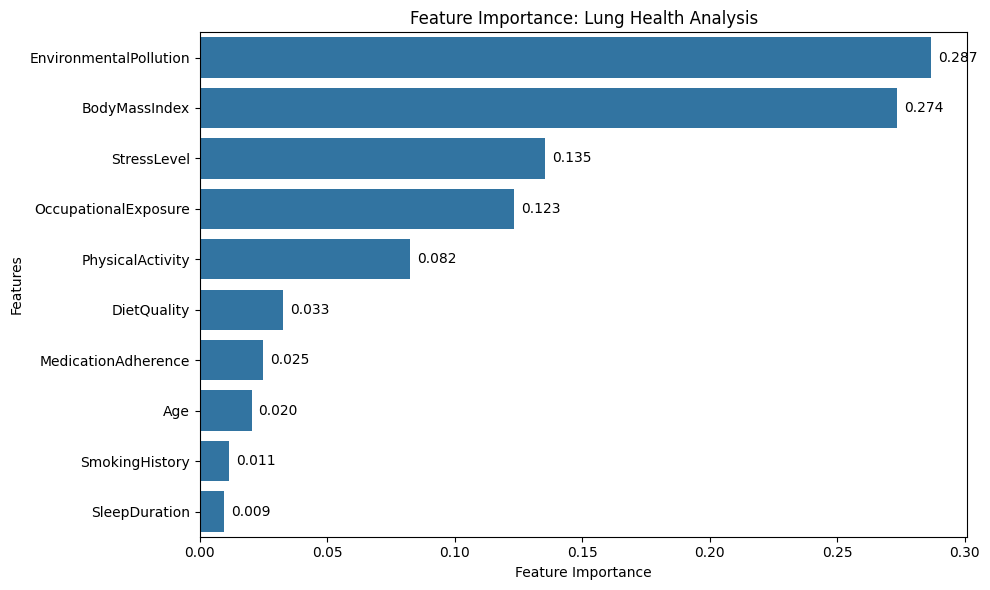

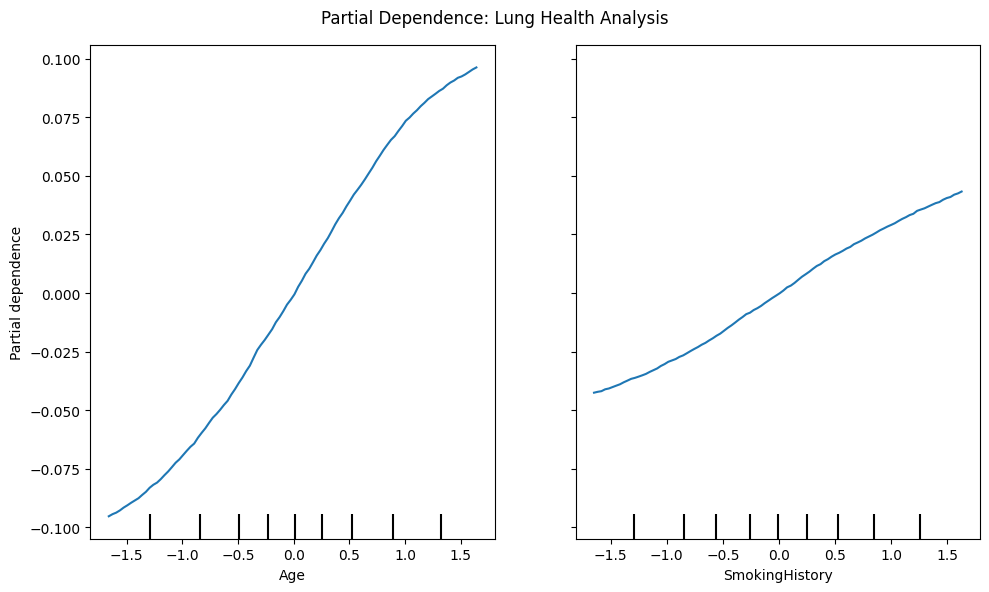

Predicted Trend in 5 years: -0.26

----- Plain-English Insight -----
For Lung Health Analysis, the model's predictions are within ±0.29 of the true values on average.
The current predicted value is -0.26, and we project it may reach -0.26 in 5 years.
This suggests an overall change of ~-0.00 over the next 5 years.


Generating insights for Lung Cancer Risk Predictions...
Accuracy:  0.92
Precision: 0.76
Recall:    0.90
F1-score:  0.83

Classification Report:
              precision    recall  f1-score   support

   No Cancer       0.97      0.93      0.95      2402
      Cancer       0.76      0.90      0.83       598

    accuracy                           0.92      3000
   macro avg       0.87      0.91      0.89      3000
weighted avg       0.93      0.92      0.93      3000



c:\Users\smart\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\smart\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


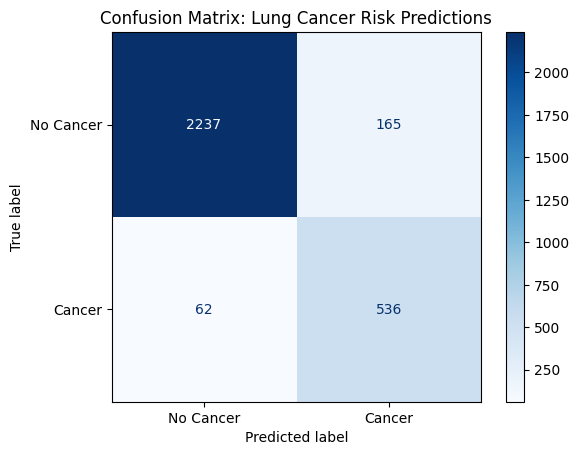

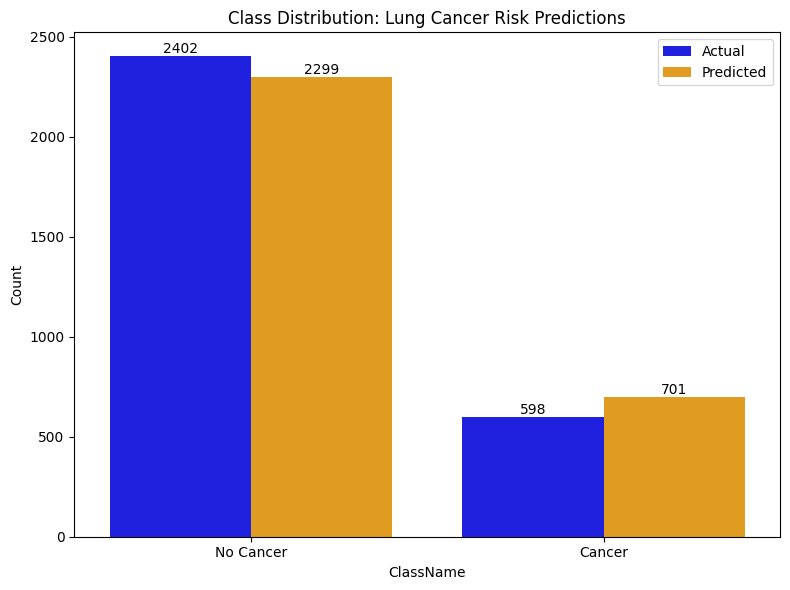

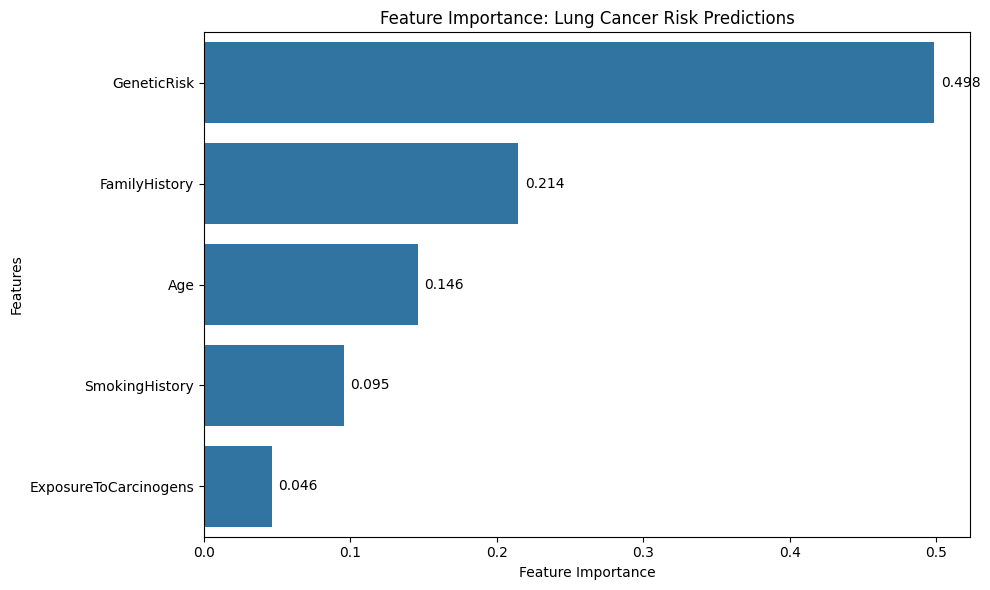

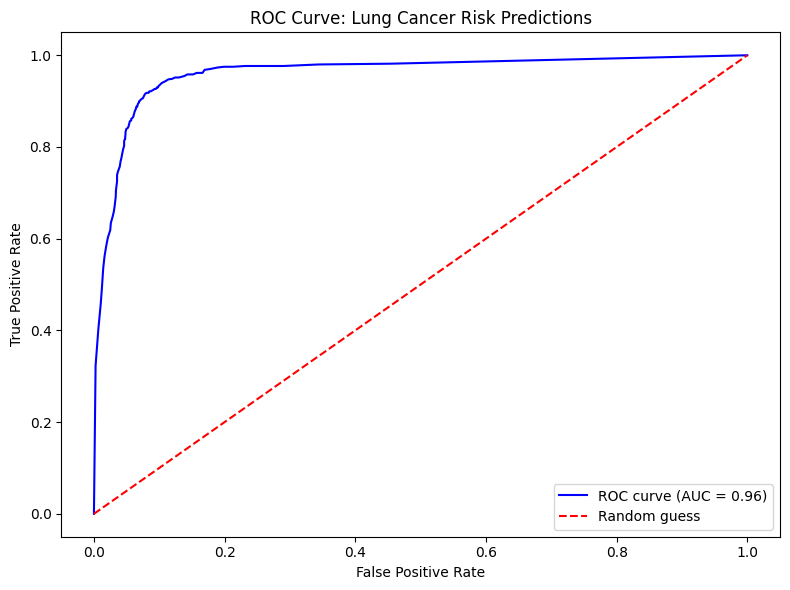

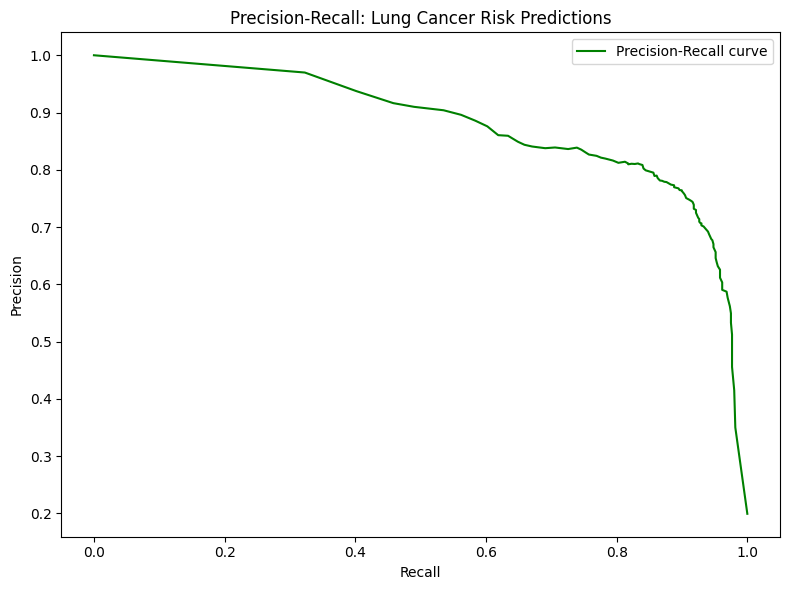

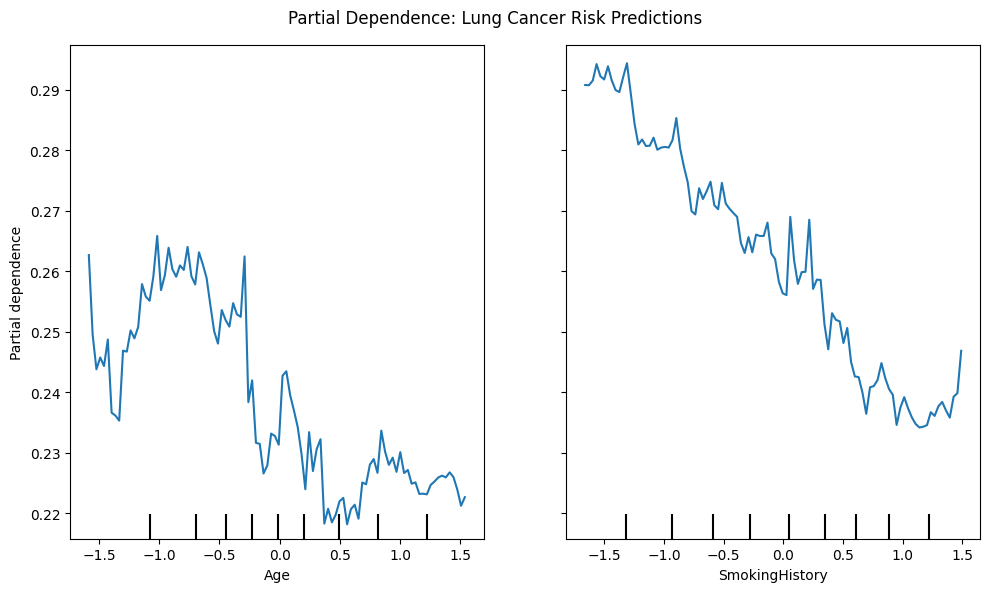

Projected Lung Cancer Risk Predictions in 5 years: 1128

----- Plain-English Insight -----
For Lung Cancer Risk Predictions, we achieved an overall accuracy of 92.4%.
Among all predicted Cancer cases, about 76.5% are truly Cancer.
Out of all real Cancer cases, we detected 89.6%.
We predict about 701 Cancer cases at present, potentially growing to ~1128 in 5 years.
These insights can help shape preventive strategies and resource allocation.


All insights generated successfully.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    r2_score,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error
)

# Optional: For partial dependence plots (requires sklearn >= 0.24)
try:
    from sklearn.inspection import partial_dependence, PartialDependenceDisplay
    HAS_PARTIAL_DEPENDENCE = True
except ImportError:
    HAS_PARTIAL_DEPENDENCE = False
    print("Partial dependence plots require sklearn >= 0.24")


###############################################################################
#                       VISUALIZATION AND METRIC FUNCTIONS                    #
###############################################################################

def plot_feature_importance(model, feature_names, title):
    """
    Plots feature importances for models that expose a 'feature_importances_' attribute.
    Annotates each bar with numerical importance value.
    """
    if not hasattr(model, "feature_importances_"):
        print(f"[WARNING] Model '{model.__class__.__name__}' does not have 'feature_importances_' attribute.")
        return
    
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=importance[indices], y=np.array(feature_names)[indices])
    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    
    # Annotate each bar with its importance value
    for i, bar in enumerate(ax.patches):
        width = bar.get_width()
        ax.annotate(f"{width:.3f}",  # you can adjust decimals
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_custom(y_true, y_pred, labels, class_names, title):
    """
    Plots the confusion matrix for classification tasks, annotating with counts (integer format).
    `class_names` is a list of strings for display labels, e.g. ["No Stroke", "Stroke"].
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    # 'values_format=".0f"' shows counts as integers instead of floats
    disp.plot(cmap="Blues", values_format=".0f")
    plt.title(title)
    plt.show()

def plot_class_distribution(y_true, y_pred, class_names, title):
    """
    Plots the distribution of actual vs. predicted classes (binary), using the provided class_names.
    Annotates each bar with its count.
    """
    actual_counts = pd.Series(y_true).value_counts().sort_index()
    predicted_counts = pd.Series(y_pred).value_counts().sort_index()

    # Prepare data for a grouped bar chart
    df_plot = pd.DataFrame({
        'ClassName': [class_names[0], class_names[1], class_names[0], class_names[1]],
        'Count': [
            actual_counts.get(0, 0), 
            actual_counts.get(1, 0),
            predicted_counts.get(0, 0), 
            predicted_counts.get(1, 0)
        ],
        'Type': ["Actual", "Actual", "Predicted", "Predicted"]
    })

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=df_plot,
        x="ClassName",
        y="Count",
        hue="Type",
        palette=["blue", "orange"],
    )
    plt.title(title)

    # Annotate each bar with its count
    for c in ax.containers:
        ax.bar_label(c, fmt="%.0f", label_type="edge")

    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_roc_curve_custom(y_true, y_scores, title):
    """
    Plots the ROC curve for binary classification.
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve_custom(y_true, y_scores, title):
    """
    Plots the Precision-Recall curve for binary classification.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', label='Precision-Recall curve')
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_partial_dependence_custom(model, X, features, feature_names, title, is_classification=True):
    """
    Plots partial dependence for the specified features.
    Only works if sklearn version >= 0.24 and for certain model types.
    
    Parameters
    ----------
    model : estimator
        The trained model (e.g., RandomForestClassifier).
    X : pd.DataFrame or np.ndarray
        The input data on which partial dependence will be computed. 
        Should have multiple rows for meaningful results.
    features : list of lists
        Example: [[0], [1]] -> two separate 1D partial dependence plots
                 [[0, 1]]  -> one 2D partial dependence plot
    feature_names : list
        List of feature names (strings).
    title : str
        Plot title.
    is_classification : bool
        If True, tries target=1 for binary classification partial dependence.
    """
    if not HAS_PARTIAL_DEPENDENCE:
        print("[WARNING] Partial dependence is not available. Requires sklearn >= 0.24.")
        return
    
    # Check if X has enough rows
    if len(X) < 2:
        print("[WARNING] X has fewer than 2 samples. Partial Dependence requires more data. Skipping.")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # For binary classification, specify target=1 to get partial dependence for the positive class
    try:
        if is_classification:
            disp = PartialDependenceDisplay.from_estimator(
                model,
                X,
                features=features,
                feature_names=feature_names,
                target=1,  # focus on the positive class
                ax=ax
            )
        else:
            disp = PartialDependenceDisplay.from_estimator(
                model,
                X,
                features=features,
                feature_names=feature_names,
                ax=ax
            )
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"[WARNING] Partial Dependence failed: {e}\n")


def plot_regression_results(y_true, y_pred, title):
    """
    Plots predicted vs. true values along with the identity line.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    """
    Plots the residuals (y_true - y_pred) distribution for a regression task.
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color='purple')
    plt.title(title)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


###############################################################################
#                      FUTURE PROJECTIONS FUNCTIONS                           #
###############################################################################

def predict_future_cases(total_cases, growth_rate=0.1, years=5):
    """
    Generates future prediction of cases based on exponential growth assumption.
    """
    future_years = np.arange(1, years + 1)
    future_cases = [int(total_cases * (1 + growth_rate) ** year) for year in future_years]
    return future_years, future_cases

def predict_future_trends(last_value, yearly_trend, years=5):
    """
    Generates future trend values for regression tasks based on a simple linear trend assumption.
    """
    future_years = np.arange(1, years + 1)
    future_trends = [last_value + (yearly_trend * year) for year in future_years]
    return future_years, future_trends


###############################################################################
#                           MAIN SCRIPT / EXAMPLE                             #
###############################################################################

if __name__ == "__main__":

    # Dictionary holding paths to your data, model, and meta-info
    # Added 'class_names' for each classification dataset to replace "Class 0/1"
    datasets = {
        "stroke_data": {
            "X_test": "stroke_data_X_test.csv",
            "y_test": "stroke_data_y_test.csv",
            "model": "stroke_data_model.pkl",
            "task": "classification",
            "insight_name": "Stroke Predictions",
            "class_names": ["No Stroke", "Stroke"]
        },
        "lung_health_data": {
            "X_test": "lung_health_data_X_test.csv",
            "y_test": "lung_health_data_y_test.csv",
            "model": "lung_health_data_model.pkl",
            "task": "regression",
            "insight_name": "Lung Health Analysis"
        },
        "lung_cancer_data": {
            "X_test": "lung_cancer_data_X_test.csv",
            "y_test": "lung_cancer_data_y_test.csv",
            "model": "lung_cancer_data_model.pkl",
            "task": "classification",
            "insight_name": "Lung Cancer Risk Predictions",
            "class_names": ["No Cancer", "Cancer"]
        }
    }

    for name, details in datasets.items():
        print(f"\nGenerating insights for {details['insight_name']}...")

        # Load test data and model
        X_test = pd.read_csv(details["X_test"])
        y_test = pd.read_csv(details["y_test"]).values.ravel()
        model = joblib.load(details["model"])

        # If classification, get custom class names or default
        class_names = details.get("class_names", ["Negative", "Positive"])

        # -----------------------------------------------------
        #  1) CLASSIFICATION TASK
        # -----------------------------------------------------
        if details["task"] == "classification":
            # If model has predict_proba, get probability scores
            if hasattr(model, "predict_proba"):
                y_scores = model.predict_proba(X_test)[:, 1]
                y_pred = (y_scores > 0.5).astype(int)
            else:
                # For classifiers without predict_proba
                y_pred = model.predict(X_test)
                # Use y_pred as a dummy probability score
                y_scores = y_pred.astype(float)

            # Ensure `y_test` is binary (just in case it's float)
            if y_test.dtype.kind in 'fc':
                y_test = (y_test > 0.5).astype(int)

            # ------------------
            #   METRICS
            # ------------------
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"Accuracy:  {accuracy:.2f}")
            print(f"Precision: {precision:.2f}")
            print(f"Recall:    {recall:.2f}")
            print(f"F1-score:  {f1:.2f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

            # ------------------
            #   PLOTS
            # ------------------
            # Confusion Matrix with custom class names
            plot_confusion_matrix_custom(
                y_test,
                y_pred,
                labels=[0, 1],
                class_names=class_names,
                title=f"Confusion Matrix: {details['insight_name']}"
            )
            # Class Distribution with custom class names
            plot_class_distribution(
                y_test,
                y_pred,
                class_names=class_names,
                title=f"Class Distribution: {details['insight_name']}"
            )
            # Feature Importances
            plot_feature_importance(
                model,
                X_test.columns,
                title=f"Feature Importance: {details['insight_name']}"
            )

            # ROC Curve
            if hasattr(model, "predict_proba"):
                plot_roc_curve_custom(
                    y_test,
                    y_scores,
                    title=f"ROC Curve: {details['insight_name']}"
                )

            # Precision-Recall Curve
            plot_precision_recall_curve_custom(
                y_test,
                y_scores,
                title=f"Precision-Recall: {details['insight_name']}"
            )

            # Optional: Partial Dependence
            if HAS_PARTIAL_DEPENDENCE:
                features_to_plot = [[0], [1]]  # Two separate 1D PDPs
                plot_partial_dependence_custom(
                    model,
                    X_test,
                    features=features_to_plot,
                    feature_names=X_test.columns,
                    title=f"Partial Dependence: {details['insight_name']}",
                    is_classification=True
                )

            # ---------------------------
            #   FUTURE PREDICTIONS
            # ---------------------------
            total_cases = y_pred.sum()
            future_years, future_cases = predict_future_cases(total_cases, growth_rate=0.1, years=5)
            
            # Summarize the future trend in plain English
            print(f"Projected {details['insight_name']} in {len(future_years)} years: {future_cases[-1]}")

            # ---------------------------
            #   PLAIN-ENGLISH INSIGHT
            # ---------------------------
            print("\n----- Plain-English Insight -----")
            print(f"For {details['insight_name']}, we achieved an overall accuracy of {accuracy*100:.1f}%.")
            print(f"Among all predicted {class_names[1]} cases, about {precision*100:.1f}% are truly {class_names[1]}.")
            print(f"Out of all real {class_names[1]} cases, we detected {recall*100:.1f}%.")
            print(f"We predict about {total_cases} {class_names[1]} cases at present, potentially growing to ~{future_cases[-1]} in 5 years.")
            print("These insights can help shape preventive strategies and resource allocation.\n")

        # -----------------------------------------------------
        #  2) REGRESSION TASK
        # -----------------------------------------------------
        elif details["task"] == "regression":
            y_pred = model.predict(X_test)

            # ------------------
            #   METRICS
            # ------------------
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            print(f"Mean Squared Error:      {mse:.2f}")
            print(f"Root Mean Squared Error: {rmse:.2f}")
            print(f"Mean Absolute Error:     {mae:.2f}")
            print(f"R-squared:               {r2:.2f}")

            # ------------------
            #   PLOTS
            # ------------------
            plot_regression_results(
                y_test,
                y_pred,
                title=f"Regression Results: {details['insight_name']}"
            )
            plot_residuals(
                y_test,
                y_pred,
                title=f"Residual Distribution: {details['insight_name']}"
            )
            plot_feature_importance(
                model,
                X_test.columns,
                title=f"Feature Importance: {details['insight_name']}"
            )

            # Optional: Partial Dependence
            if HAS_PARTIAL_DEPENDENCE:
                # For 1D partial dependence on two features separately:
                features_to_plot = [[0], [1]]
                try:
                    plot_partial_dependence_custom(
                        model,
                        X_test,
                        features=features_to_plot,
                        feature_names=X_test.columns,
                        title=f"Partial Dependence: {details['insight_name']}",
                        is_classification=True  # or False, depending on your case
                    )
                except ValueError as e:
                    print(f"[WARNING] Partial Dependence failed: {e}")
                    print("[INFO] Could not compute partial dependence for these features.\n")

            # ---------------------------
            #   FUTURE TREND
            # ---------------------------
            # If there's only 1 sample, avoid division by zero
            if len(y_pred) > 1:
                yearly_trend = (y_pred[-1] - y_pred[0]) / (len(y_pred) - 1)
            else:
                yearly_trend = 0
            last_value = y_pred[-1]
            future_years, future_trends = predict_future_trends(last_value, yearly_trend, years=5)

            # Print a simple future trend
            print(f"Predicted Trend in {len(future_years)} years: {future_trends[-1]:.2f}")

            # ---------------------------
            #   PLAIN-ENGLISH INSIGHT
            # ---------------------------
            print("\n----- Plain-English Insight -----")
            print(f"For {details['insight_name']}, the model's predictions are within ±{rmse:.2f} of the true values on average.")
            print(f"The current predicted value is {last_value:.2f}, and we project it may reach {future_trends[-1]:.2f} in 5 years.")
            print(f"This suggests an overall change of ~{(future_trends[-1]-last_value):.2f} over the next 5 years.\n")

    print("\nAll insights generated successfully.")